In [13]:
import glob
import pandas as pd
import wandb
import itertools
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

In [14]:
api = wandb.Api()
eps = 1e-3

In [15]:

def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

def get_diversity(seqs):
    sample_states1 = torch.tensor(seqs)
    sample_states2 = sample_states1.clone()
    dist_matrix = torch.cdist(sample_states1, sample_states2, p=2)
    dist_upper_triangle = torch.triu(dist_matrix, diagonal=1)
    dist_vector = dist_upper_triangle[dist_upper_triangle != 0]
    return dist_vector

In [22]:
# HARTMANN
data_type = "Hartmann"
oracle_maximize = True
k = 10
AL_BATCH_SIZE = 10

sf_logdir1 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-05_01-08-33"
sf_run_path1 = "alexhg/Hartmann budget data set/nioe5ca4"
# 2 and 3 were of different seeds but started at the same time so logged to the same folder
sf_logdir2 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-04_06-27-13"
sf_run_path2 = "alexhg/Hartmann budget data set/u3jlu0gs"
sf_logdir3 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-04_06-27-13"
sf_run_path3 = "alexhg/Hartmann budget data set/ladvzph0"
sf_logdirs = [sf_logdir1, sf_logdir2, sf_logdir3]
sf_run_paths = [sf_run_path1, sf_run_path2, sf_run_path3]

# mf_train_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/mf/data_train.csv"
# mf_test_dataset = "/home/mila/n/nikita.saxena/activelearning/storage/amp/mf/data_test.csv"
mf_logdir1 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-05_10-51-53"
mf_run_path1 = "alexhg/Hartmann budget data set/bytcboio"
mf_logdir2 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-04_06-27-11"
mf_run_path2 = "alexhg/Hartmann budget data set/n6i5yw72"
mf_logdir3 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-04_06-27-12"
mf_run_path3 = "alexhg/Hartmann budget data set/wkimrg0l"
mf_logdirs = [mf_logdir1, mf_logdir2, mf_logdir3]
mf_run_paths = [mf_run_path1, mf_run_path2, mf_run_path3]

In [7]:
# # BRANIN
# data_type = "Branin"
# oracle_maximize = False
# k = 50
# AL_BATCH_SIZE = 30

# sf_logdir1 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-03_06-35-40"
# sf_run_path1 = "alexhg/Branin budget data set/p6nu2nzx"
# sf_logdir2 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-03_06-32-45"
# sf_run_path2 = "alexhg/Branin budget data set/yvk5tox2"
# sf_logdir3 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-03_18-49-33"
# sf_run_path3 = "alexhg/Branin budget data set/27japxej"
# sf_logdirs = [sf_logdir1, sf_logdir2, sf_logdir3]
# sf_run_paths = [sf_run_path1, sf_run_path2, sf_run_path3]

# mf_logdir1 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-04_22-24-48"
# mf_run_path1 = "alexhg/Branin budget data set/cijnbh4w"
# mf_logdir2 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-03_06-41-16"
# mf_run_path2 = "alexhg/Branin budget data set/lwzlgxvj"
# mf_logdir3 = "/home/mila/n/nikita.saxena/activelearning/storage/scratch/2023-05-03_06-41-50"
# mf_run_path3 = "alexhg/Branin budget data set/g557nx3y"
# mf_logdirs = [mf_logdir1, mf_logdir2, mf_logdir3]
# mf_run_paths = [mf_run_path1, mf_run_path2, mf_run_path3]

In [23]:
def get_performance(logdir, run_path, oracle_maximize, eps=1e-3):

    pkl_file = find_pkl_file(logdir)
    
    culm_pkl = pd.read_pickle(pkl_file)
    culm_samples = culm_pkl['cumulative_sampled_samples']
    culm_energies = culm_pkl['cumulative_sampled_energies']


    # metric_diversity = []
    metric_energy = []
    metric_cost = []
    # mean_energy_from_wandb = run.history(keys=["mean_energy_top{}".format(k)])
    # mean_energy_from_wandb = mean_energy_from_wandb["mean_energy_top{}".format(k)].values
    run = api.run(run_path)
    post_al_cum_cost = run.history(keys=["post_al_cum_cost"])
    post_al_cum_cost = np.unique(post_al_cum_cost['post_al_cum_cost'])

    steps = np.arange(start = AL_BATCH_SIZE, stop = len(culm_samples), step = AL_BATCH_SIZE, dtype=int)
    for idx, upper_bound in enumerate(steps):
        culm_samples_curr_iter = culm_samples[0:upper_bound]
        culm_sampled_energies_curr_iter = culm_energies[0:upper_bound]

        idx_topk = torch.argsort(culm_sampled_energies_curr_iter, descending=oracle_maximize)[:k].tolist()
        samples_topk = [culm_samples_curr_iter[i] for i in idx_topk]
        energies_topk = [culm_sampled_energies_curr_iter[i] for i in idx_topk]
        mean_energy_topk = torch.mean(torch.FloatTensor(energies_topk))
        # diff = abs(mean_energy_topk-mean_energy_from_wandb[idx])
        # if diff>eps:
            # print("ERROR: energy from wandb does not match for the {}th iteration".format(idx))
        metric_energy.append(mean_energy_topk.numpy())
        # mean_diversity_topk = get_diversity(samples_topk)
        # metric_diversity.append(mean_diversity_topk.numpy())
        metric_cost.append(post_al_cum_cost[idx])

    # PLOT METRICS
    reward = np.array(metric_energy)
    # diversity = np.array(metric_diversity)
    cost = np.array(metric_cost)

    return reward, cost

In [24]:
# iterate over 1, 2, 3 and create three variables sf1, sf2, sf3
import sys
max_iter = 0
for i in range(3):
    setattr(sys.modules[__name__], "sf_tuple{}".format(i+1), get_performance(sf_logdirs[i], sf_run_paths[i], oracle_maximize=oracle_maximize))
    setattr(sys.modules[__name__], "mf_tuple{}".format(i+1), get_performance(mf_logdirs[i], mf_run_paths[i], oracle_maximize=oracle_maximize))
    max_iter = max(max_iter, len(getattr(sys.modules[__name__], "mf_tuple{}".format(i+1))[0]))

for i in range(3):
    for j in range(3):
        sf_tuple = getattr(sys.modules[__name__], "sf_tuple{}".format(i+1))
        mf_tuple = getattr(sys.modules[__name__], "mf_tuple{}".format(j+1))
        sf_reward = sf_tuple[0]
        sf_cost = sf_tuple[1]
        mf_reward = mf_tuple[0]
        mf_cost = mf_tuple[1]
        sf_reward = np.append(sf_reward, np.repeat(sf_reward[-1], max_iter-len(sf_reward)))
        sf_cost = np.append(sf_cost, np.repeat(sf_cost[-1], max_iter-len(sf_cost)))
        mf_reward = np.append(mf_reward, np.repeat(mf_reward[-1], max_iter-len(mf_reward)))
        mf_cost = np.append(mf_cost, np.repeat(mf_cost[-1], max_iter-len(mf_cost)))
        setattr(sys.modules[__name__], "sf_tuple{}".format(i+1), (sf_reward, sf_cost))
        setattr(sys.modules[__name__], "mf_tuple{}".format(j+1), (mf_reward, mf_cost))


In [25]:
metrics = ['reward', 'cost']
for metric in metrics:
    setattr(sys.modules[__name__], "cum_sf_{}".format(metric), np.stack([getattr(sys.modules[__name__], "sf_tuple{}".format(i+1))[metrics.index(metric)] for i in range(3)], axis=0))
    setattr(sys.modules[__name__], "sf_{}".format(metric), np.mean(getattr(sys.modules[__name__], "cum_sf_{}".format(metric)), axis=0))
    setattr(sys.modules[__name__], "std_sf_{}".format(metric), np.std(getattr(sys.modules[__name__], "cum_sf_{}".format(metric)), axis=0))
    setattr(sys.modules[__name__], "cum_mf_{}".format(metric), np.stack([getattr(sys.modules[__name__], "mf_tuple{}".format(i+1))[metrics.index(metric)] for i in range(3)], axis=0))
    setattr(sys.modules[__name__], "mf_{}".format(metric), np.mean(getattr(sys.modules[__name__], "cum_mf_{}".format(metric)), axis=0))
    setattr(sys.modules[__name__], "std_mf_{}".format(metric), np.std(getattr(sys.modules[__name__], "cum_mf_{}".format(metric)), axis=0))

# cum_sf_reward = np.stack([sf_tuple1[0], sf_tuple2[0], sf_tuple3[0]], axis=0)
# avg_sf_reward = np.mean(cum_sf_reward, axis=0)
# std_sf_reward = np.std(cum_sf_reward, axis=0)

# cum_sf_diversity = np.stack([sf_tuple1[1], sf_tuple2[1], sf_tuple3[1]], axis=0)
# avg_sf_diversity = np.mean(cum_sf_diversity, axis=0)
# std_sf_diversity = np.std(cum_sf_diversity, axis=0)

# cum_sf_cost = np.stack([sf_tuple1[2], sf_tuple2[2], sf_tuple3[2]], axis=0)
# avg_sf_cost = np.mean(cum_sf_cost, axis=0)
# std_sf_cost = np.std(cum_sf_cost, axis=0)

# cum_mf_reward = np.stack([mf_tuple1[0], mf_tuple2[0], mf_tuple3[0]], axis=0)
# avg_mf_reward = np.mean(cum_mf_reward, axis=0)
# std_mf_reward = np.std(cum_mf_reward, axis=0)

# cum_mf_diversity = np.stack([mf_tuple1[1], mf_tuple2[1], mf_tuple3[1]], axis=0)
# avg_mf_diversity = np.mean(cum_mf_diversity, axis=0)
# std_mf_diversity = np.std(cum_mf_diversity, axis=0)

# cum_mf_cost = np.stack([mf_tuple1[3], mf_tuple2[3], mf_tuple3[3]], axis=0)
# avg_mf_cost = np.mean(cum_mf_cost, axis=0)
# std_mf_cost = np.std(cum_mf_cost, axis=0)

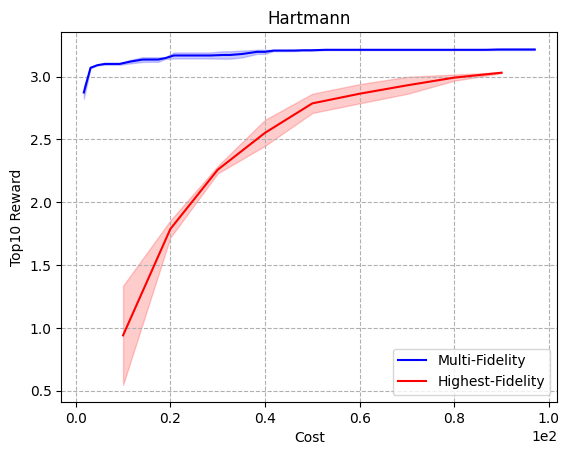

In [27]:
# Create a single subplot
fig, ax = plt.subplots()

# Plot the two line curves
mf_plot = ax.plot(mf_cost, mf_reward, color='blue', label='Multi-Fidelity')
sf_plot = ax.plot(sf_cost, sf_reward, color='red', label='Highest-Fidelity')
ax.fill_between(sf_cost, sf_reward-std_sf_reward, sf_reward+std_sf_reward, alpha=0.2, color='red')
ax.fill_between(mf_cost, mf_reward-std_mf_reward, mf_reward+std_mf_reward, alpha=0.2, color='blue')

# Set the title and axis labels
ax.set_title('{}'.format(data_type))
ax.set_xlabel('Cost')
ax.set_ylabel('Top{} Reward'.format(k))
# add grid
ax.grid(True, linestyle='--')
# convert cost labels to exponential
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Add a legend
ax.legend(loc='lower right')

# Display the plot
plt.show()

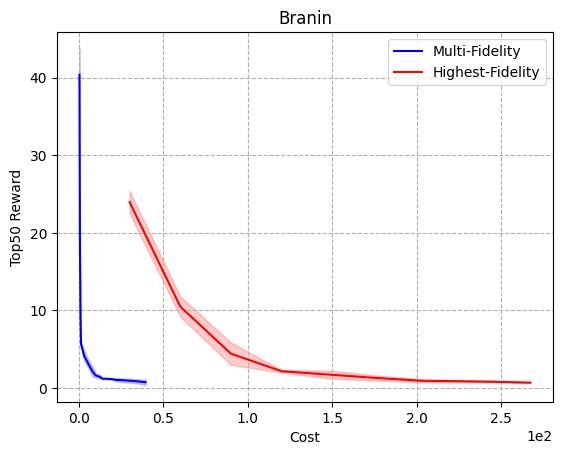

In [12]:
# Create a single subplot
fig, ax = plt.subplots()

# Plot the two line curves
mf_plot = ax.plot(mf_cost, mf_reward, color='blue', label='Multi-Fidelity')
sf_plot = ax.plot(sf_cost, sf_reward, color='red', label='Highest-Fidelity')
ax.fill_between(sf_cost, sf_reward-std_sf_reward, sf_reward+std_sf_reward, alpha=0.2, color='red')
ax.fill_between(mf_cost, mf_reward-std_mf_reward, mf_reward+std_mf_reward, alpha=0.2, color='blue')

# Set the title and axis labels
ax.set_title('{}'.format(data_type))
ax.set_xlabel('Cost')
ax.set_ylabel('Top{} Reward'.format(k))
# add grid
ax.grid(True, linestyle='--')
# convert cost labels to exponential
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Add a legend
ax.legend(loc='upper right')

# Display the plot
plt.show()